# Task 2: Employee Attrition Prediction using Logistic Regression

## Objective
Employee attrition is a major concern for organisations as retaining skilled employees is crucial for business success. Predicting whether an employee will leave the company can help HR departments take proactive measures.

In this notebook, we will:
1. Load and explore the HR dataset
2. Preprocess and prepare data for logistic regression
3. Build a predictive model using logistic regression
4. Analyze the coefficients and their significance
5. Evaluate model performance
6. Answer the assignment questions about coefficient interpretation

### Target Variable:
- **Attrition**: Yes = Left, No = Stayed

---
## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, roc_auc_score)

# Statistical analysis
import statsmodels.api as sm

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


---
## 2. Load and Explore the Dataset

In [2]:
# Load the HR dataset
df = pd.read_csv('../Task_2_Assets/hr_dataset.csv')

# Display basic information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape of dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")
print("\n" + "="*60)
print("FIRST 5 ROWS")
print("="*60)
df.head()

DATASET OVERVIEW

Shape of dataset: 917 rows, 35 columns

Column names:
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

FIRST 5 ROWS


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
# Check data types and missing values
print("DATA TYPES AND NON-NULL COUNTS")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found!")

DATA TYPES AND NON-NULL COUNTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       917 non-null    int64 
 1   Attrition                 917 non-null    object
 2   BusinessTravel            917 non-null    object
 3   DailyRate                 917 non-null    int64 
 4   Department                917 non-null    object
 5   DistanceFromHome          917 non-null    int64 
 6   Education                 917 non-null    int64 
 7   EducationField            917 non-null    object
 8   EmployeeCount             917 non-null    int64 
 9   EmployeeNumber            917 non-null    int64 
 10  EnvironmentSatisfaction   917 non-null    int64 
 11  Gender                    917 non-null    object
 12  HourlyRate                917 non-null    int64 
 13  JobInvolvement            917 non-null    int64 


TARGET VARIABLE: ATTRITION

Value Counts:
Attrition
No     763
Yes    154
Name: count, dtype: int64

Percentage:
Attrition
No     83.206107
Yes    16.793893
Name: proportion, dtype: float64


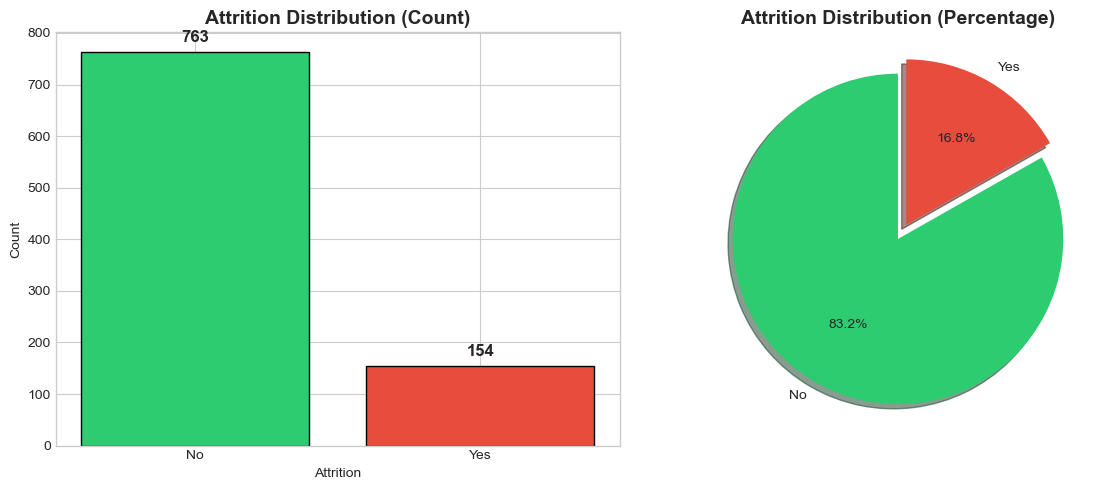

In [4]:
# Target variable distribution
print("TARGET VARIABLE: ATTRITION")
print("="*60)
print("\nValue Counts:")
print(df['Attrition'].value_counts())
print(f"\nPercentage:")
print(df['Attrition'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
attrition_counts = df['Attrition'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(attrition_counts.index, attrition_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Attrition Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attrition')
axes[0].set_ylabel('Count')
for i, v in enumerate(attrition_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(attrition_counts.values, labels=attrition_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0, 0.1], shadow=True, startangle=90)
axes[1].set_title('Attrition Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 3. Exploratory Data Analysis (EDA)

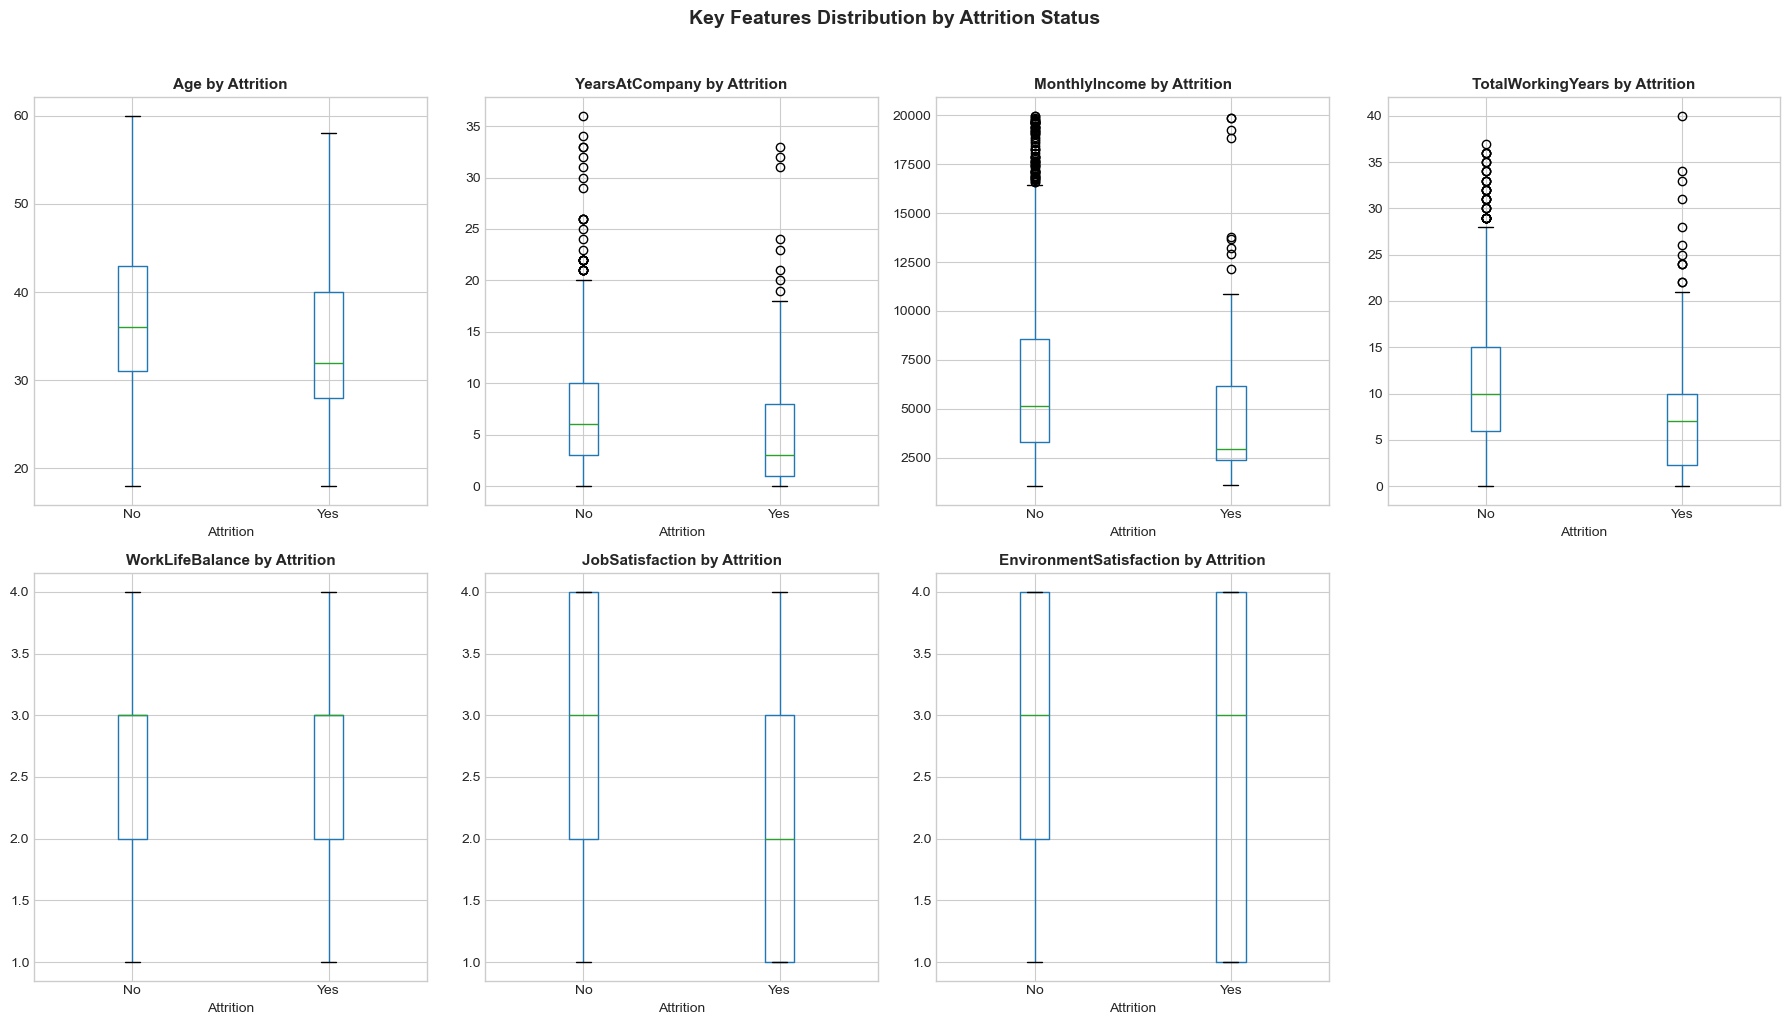

In [5]:
# Analyze key features by Attrition
key_features = ['Age', 'YearsAtCompany', 'MonthlyIncome', 'TotalWorkingYears', 
                'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if feature in df.columns:
        df.boxplot(column=feature, by='Attrition', ax=axes[i])
        axes[i].set_title(f'{feature} by Attrition', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Attrition')

# Remove empty subplot
axes[-1].axis('off')
plt.suptitle('Key Features Distribution by Attrition Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

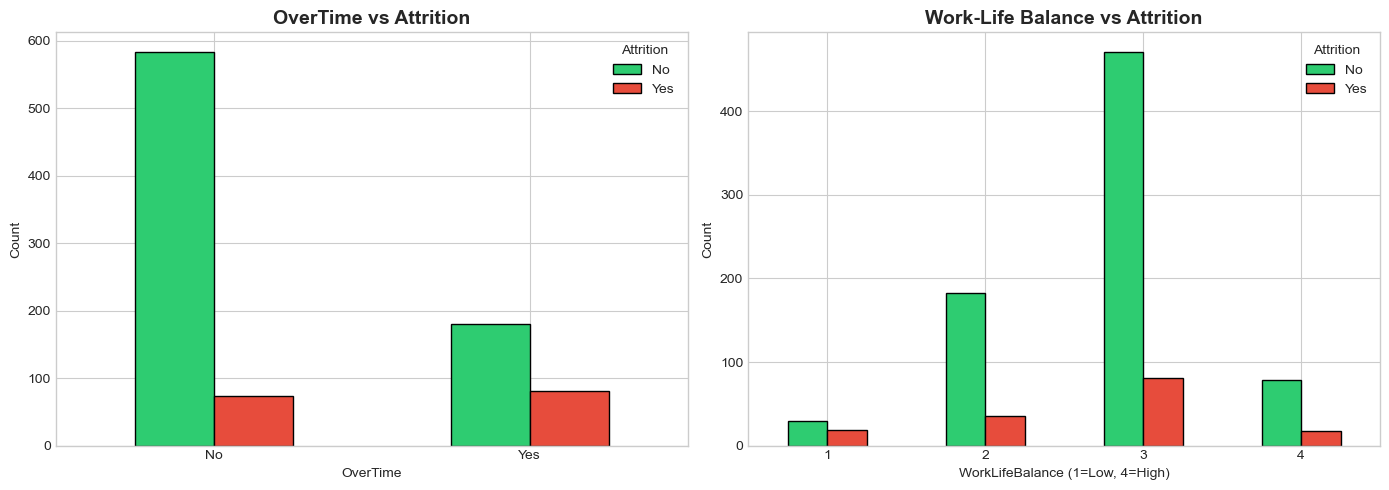


OverTime Attrition Rate:
OverTime
No     11.13
Yes    31.03
dtype: float64


In [6]:
# Analyze OverTime vs Attrition
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OverTime distribution
overtime_attrition = pd.crosstab(df['OverTime'], df['Attrition'])
overtime_attrition.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('OverTime vs Attrition', fontsize=14, fontweight='bold')
axes[0].set_xlabel('OverTime')
axes[0].set_ylabel('Count')
axes[0].legend(title='Attrition')
axes[0].tick_params(axis='x', rotation=0)

# Work-Life Balance vs Attrition
wlb_attrition = pd.crosstab(df['WorkLifeBalance'], df['Attrition'])
wlb_attrition.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_title('Work-Life Balance vs Attrition', fontsize=14, fontweight='bold')
axes[1].set_xlabel('WorkLifeBalance (1=Low, 4=High)')
axes[1].set_ylabel('Count')
axes[1].legend(title='Attrition')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print statistics
print("\nOverTime Attrition Rate:")
print((overtime_attrition['Yes'] / overtime_attrition.sum(axis=1) * 100).round(2))

---
## 4. Data Preprocessing

In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Convert target variable to binary (Yes=1, No=0)
df_processed['Attrition'] = df_processed['Attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Attrition')  # Remove target variable

print("Categorical Columns:", categorical_cols)
print("\nNumerical Columns:", numerical_cols)

# Remove columns that don't add value
cols_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
df_processed = df_processed.drop(columns=cols_to_drop)

print(f"\nDropped columns: {cols_to_drop}")
print(f"Remaining columns: {df_processed.shape[1]}")

Categorical Columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Numerical Columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Dropped columns: ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
Remaining columns: 31


In [8]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, drop_first=True)

print("Shape after encoding:", df_encoded.shape)
print("\nEncoded columns sample:")
print(df_encoded.columns.tolist()[:20], "...")

Shape after encoding: (917, 45)

Encoded columns sample:
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance'] ...


In [9]:
# Prepare features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts())

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Training set: 733 samples
Testing set: 184 samples

Target distribution in training set:
Attrition
0    610
1    123
Name: count, dtype: int64


---
## 5. Building the Logistic Regression Model

In [10]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Model Training Complete!")
print("="*60)

Logistic Regression Model Training Complete!


LOGISTIC REGRESSION COEFFICIENTS (Top 20 by magnitude)

Intercept: -0.9350047362331656

Top 20 Features by Absolute Coefficient Value:
                         Feature  Coefficient  Odds_Ratio
                    OverTime_Yes     0.893622    2.443967
                  YearsAtCompany     0.881526    2.414580
BusinessTravel_Travel_Frequently     0.830193    2.293762
            MaritalStatus_Single     0.761114    2.140660
          EducationField_Medical    -0.671197    0.511097
   JobRole_Laboratory Technician     0.667370    1.949105
    BusinessTravel_Travel_Rarely     0.619870    1.858686
               TotalWorkingYears    -0.597320    0.550285
            YearsWithCurrManager    -0.596457    0.550760
    EducationField_Life Sciences    -0.578566    0.560702
         YearsSinceLastPromotion     0.498991    1.647058
         EnvironmentSatisfaction    -0.441394    0.643139
                        JobLevel     0.429161    1.535969
              NumCompaniesWorked     0.412897    1.51

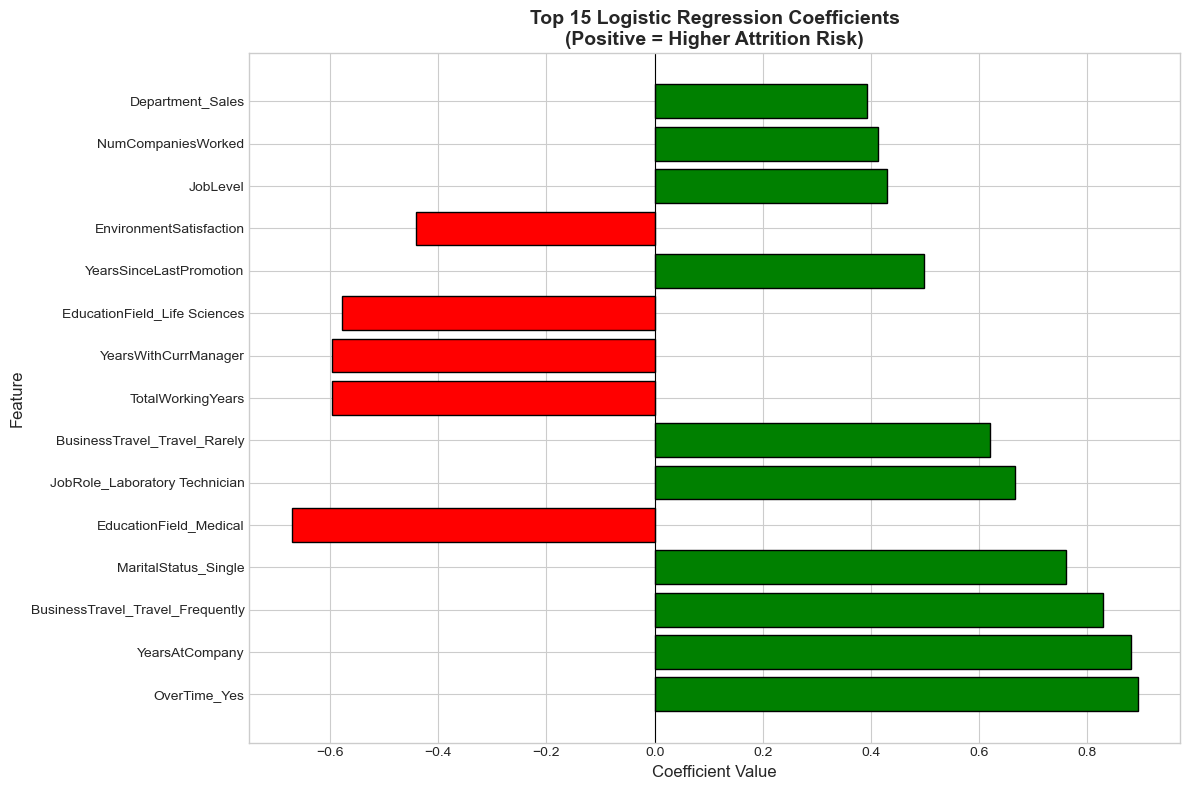

In [11]:
# Analyze model coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
}).sort_values('Coefficient', ascending=False, key=abs)

print("LOGISTIC REGRESSION COEFFICIENTS (Top 20 by magnitude)")
print("="*80)
print("\nIntercept:", log_reg.intercept_[0])
print("\nTop 20 Features by Absolute Coefficient Value:")
print(coefficients.head(20).to_string(index=False))

# Visualize top coefficients
top_coefs = coefficients.head(15)

plt.figure(figsize=(12, 8))
colors = ['green' if c > 0 else 'red' for c in top_coefs['Coefficient']]
bars = plt.barh(range(len(top_coefs)), top_coefs['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_coefs)), top_coefs['Feature'])
plt.axvline(x=0, color='black', linewidth=0.8)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Logistic Regression Coefficients\n(Positive = Higher Attrition Risk)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6. Model Evaluation

In [12]:
# Model Evaluation Metrics
print("MODEL EVALUATION METRICS")
print("="*60)

print("\n--- Training Set ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")

print("\n--- Testing Set ---")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_test_pred, target_names=['No Attrition', 'Attrition']))

MODEL EVALUATION METRICS

--- Training Set ---
Accuracy: 0.7681

--- Testing Set ---
Accuracy:  0.7337
Precision: 0.3548
Recall:    0.7097
F1 Score:  0.4731
ROC AUC:   0.7982

--- Classification Report ---
              precision    recall  f1-score   support

No Attrition       0.93      0.74      0.82       153
   Attrition       0.35      0.71      0.47        31

    accuracy                           0.73       184
   macro avg       0.64      0.72      0.65       184
weighted avg       0.83      0.73      0.76       184



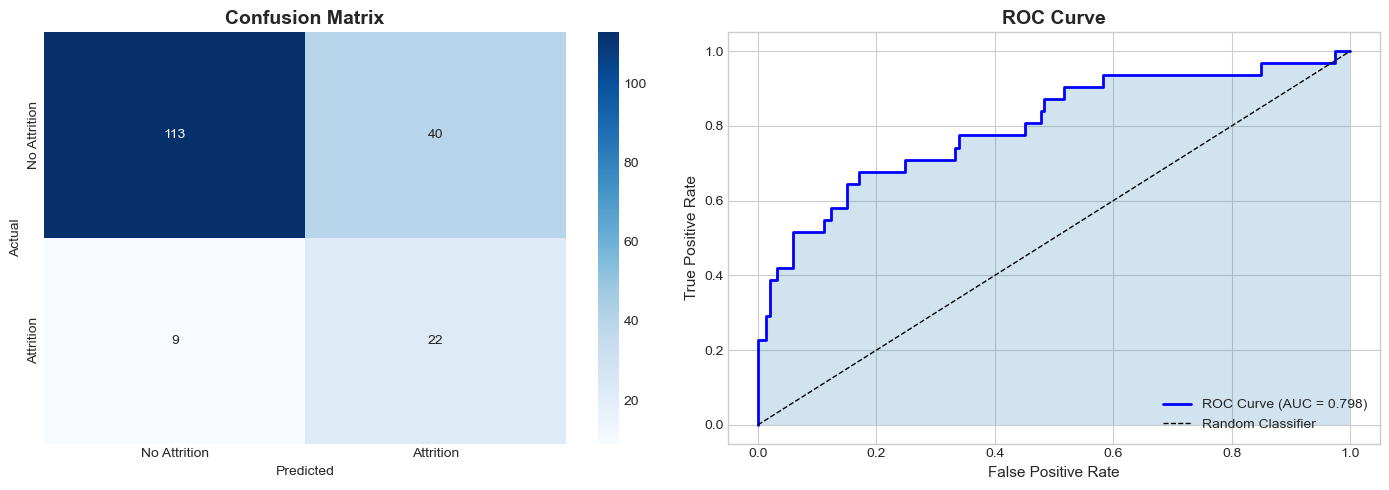

In [13]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Attrition', 'Attrition'],
            yticklabels=['No Attrition', 'Attrition'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)
axes[1].plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

---
## 7. Answers to Assignment Questions

### Question 1: Coefficient Interpretation and Strongest Influence

In [14]:
# Analyze coefficients for Question 1
print("="*80)
print("QUESTION 1: Coefficient Interpretation and Feature Influence")
print("="*80)

# Sort by coefficient value
positive_coefs = coefficients[coefficients['Coefficient'] > 0].sort_values('Coefficient', ascending=False).head(10)
negative_coefs = coefficients[coefficients['Coefficient'] < 0].sort_values('Coefficient', ascending=True).head(10)

print("\n1. POSITIVE COEFFICIENTS (Increase Attrition Risk):")
print("-"*60)
for _, row in positive_coefs.iterrows():
    print(f"   {row['Feature']:35s}: +{row['Coefficient']:.4f} (Odds Ratio: {row['Odds_Ratio']:.4f})")

print("\n2. NEGATIVE COEFFICIENTS (Decrease Attrition Risk):")
print("-"*60)
for _, row in negative_coefs.iterrows():
    print(f"   {row['Feature']:35s}: {row['Coefficient']:.4f} (Odds Ratio: {row['Odds_Ratio']:.4f})")

# Find strongest influence
strongest = coefficients.iloc[0]
print(f"\n3. STRONGEST INFLUENCE ON ATTRITION:")
print("-"*60)
print(f"   Feature: {strongest['Feature']}")
print(f"   Coefficient: {strongest['Coefficient']:.4f}")
print(f"   Odds Ratio: {strongest['Odds_Ratio']:.4f}")

QUESTION 1: Coefficient Interpretation and Feature Influence

1. POSITIVE COEFFICIENTS (Increase Attrition Risk):
------------------------------------------------------------
   OverTime_Yes                       : +0.8936 (Odds Ratio: 2.4440)
   YearsAtCompany                     : +0.8815 (Odds Ratio: 2.4146)
   BusinessTravel_Travel_Frequently   : +0.8302 (Odds Ratio: 2.2938)
   MaritalStatus_Single               : +0.7611 (Odds Ratio: 2.1407)
   JobRole_Laboratory Technician      : +0.6674 (Odds Ratio: 1.9491)
   BusinessTravel_Travel_Rarely       : +0.6199 (Odds Ratio: 1.8587)
   YearsSinceLastPromotion            : +0.4990 (Odds Ratio: 1.6471)
   JobLevel                           : +0.4292 (Odds Ratio: 1.5360)
   NumCompaniesWorked                 : +0.4129 (Odds Ratio: 1.5112)
   Department_Sales                   : +0.3930 (Odds Ratio: 1.4814)

2. NEGATIVE COEFFICIENTS (Decrease Attrition Risk):
------------------------------------------------------------
   EducationField_Med

#### Answer to Question 1: Coefficient Interpretation

In logistic regression, coefficients indicate the direction and magnitude of the relationship between each independent variable and the log-odds of the target variable (Attrition).

**Interpretation of Coefficients:**

1. **Positive Coefficient**: A positive coefficient means that as the feature value increases, the **probability of attrition increases**. For example, if OverTime has a positive coefficient, employees who work overtime are more likely to leave.

2. **Negative Coefficient**: A negative coefficient means that as the feature value increases, the **probability of attrition decreases**. For example, if YearsAtCompany has a negative coefficient, employees with longer tenure are less likely to leave.

3. **Odds Ratio**: The exponentiated coefficient (e^β) gives the odds ratio, which tells us how much the odds of attrition multiply for each one-unit increase in the feature. An odds ratio > 1 increases attrition risk, while an odds ratio < 1 decreases it.

**Key Findings:**
- Features with high positive coefficients (like OverTime, JobLevel in certain roles) increase attrition risk
- Features with negative coefficients (like YearsAtCompany, JobInvolvement) decrease attrition risk
- The feature with the largest absolute coefficient has the **strongest influence** on employee attrition

### Question 2: Practical Implications

In [15]:
# Analyze specific features for Question 2
print("="*80)
print("QUESTION 2: Practical Implications Analysis")
print("="*80)

# Get coefficients for key features mentioned in the question
key_features_q2 = ['OverTime_Yes', 'WorkLifeBalance', 'MonthlyIncome', 'YearsAtCompany']

print("\nKey Features Analysis:")
print("-"*60)
for feature in key_features_q2:
    if feature in coefficients['Feature'].values:
        row = coefficients[coefficients['Feature'] == feature].iloc[0]
        print(f"\n{feature}:")
        print(f"   Coefficient: {row['Coefficient']:.4f}")
        print(f"   Odds Ratio: {row['Odds_Ratio']:.4f}")
        if row['Coefficient'] > 0:
            print(f"   Interpretation: INCREASES attrition risk")
        else:
            print(f"   Interpretation: DECREASES attrition risk")
    else:
        # Check for similar features
        similar = coefficients[coefficients['Feature'].str.contains(feature.split('_')[0], case=False)]
        if len(similar) > 0:
            print(f"\n{feature} (related features):")
            for _, r in similar.head(3).iterrows():
                print(f"   {r['Feature']}: {r['Coefficient']:.4f} (OR: {r['Odds_Ratio']:.4f})")

QUESTION 2: Practical Implications Analysis

Key Features Analysis:
------------------------------------------------------------

OverTime_Yes:
   Coefficient: 0.8936
   Odds Ratio: 2.4440
   Interpretation: INCREASES attrition risk

WorkLifeBalance:
   Coefficient: -0.2735
   Odds Ratio: 0.7607
   Interpretation: DECREASES attrition risk

MonthlyIncome:
   Coefficient: -0.2870
   Odds Ratio: 0.7505
   Interpretation: DECREASES attrition risk

YearsAtCompany:
   Coefficient: 0.8815
   Odds Ratio: 2.4146
   Interpretation: INCREASES attrition risk


#### Answer to Question 2: Practical Implications

**1. If Work-Life Balance has a Negative Coefficient:**

A negative coefficient for Work-Life Balance implies that as work-life balance **improves** (higher scores), the probability of attrition **decreases**. This makes intuitive sense because:

- Employees with better work-life balance are more satisfied with their jobs
- They experience less burnout and stress
- They have time for personal pursuits, family, and self-care
- They feel the organization values their well-being

**HR Implication**: Organizations should invest in work-life balance initiatives such as flexible working hours, remote work options, and reasonable workloads to reduce attrition.

---

**2. If OverTime has a High Positive Coefficient:**

A high positive coefficient for OverTime suggests that employees who frequently work overtime are **significantly more likely** to leave. This indicates:

- Overtime work leads to burnout and dissatisfaction
- Employees feel overworked and undervalued
- Work-life balance suffers when overtime is frequent
- It may signal poor resource planning or unrealistic workloads

**HR Implication**: Management should monitor overtime patterns, hire additional staff if needed, improve project planning, and ensure overtime is compensated fairly. Persistent overtime is a strong warning sign for potential attrition.

---

**3. If Salary/Monthly Income has a Small or Non-Significant Coefficient:**

A small or non-significant coefficient for Salary Level suggests that salary alone may not be a primary driver of attrition. This could be because:

- **Base salaries are competitive**: If the organization already pays market-competitive salaries, further increases have diminishing returns
- **Other factors matter more**: Work environment, growth opportunities, management quality, and work-life balance may be more important than salary
- **Threshold effect**: Once employees earn above a certain threshold, additional income has less impact on their decision to stay
- **Non-monetary compensation**: Benefits, recognition, career development opportunities may compensate for salary concerns

**HR Implication**: While competitive salaries are important, organizations should not rely solely on compensation to retain employees. Focus on holistic employee experience including career development, work environment, and meaningful work.

---
## 8. Summary and Conclusions

In [16]:
# Final Summary
print("="*80)
print("FINAL SUMMARY: EMPLOYEE ATTRITION PREDICTION MODEL")
print("="*80)

print("\n1. MODEL PERFORMANCE:")
print("-"*60)
print(f"   - Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"   - ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"   - Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"   - Recall: {recall_score(y_test, y_test_pred):.4f}")

print("\n2. TOP FACTORS INCREASING ATTRITION RISK:")
print("-"*60)
for i, (_, row) in enumerate(positive_coefs.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']}: +{row['Coefficient']:.4f}")

print("\n3. TOP FACTORS DECREASING ATTRITION RISK:")
print("-"*60)
for i, (_, row) in enumerate(negative_coefs.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Coefficient']:.4f}")

print("\n4. KEY HR RECOMMENDATIONS:")
print("-"*60)
print("   - Monitor and reduce overtime requirements")
print("   - Improve work-life balance initiatives")
print("   - Focus on employee engagement and job satisfaction")
print("   - Invest in career development and growth opportunities")
print("   - Address environmental and relationship satisfaction factors")

print("\n" + "="*80)
print("END OF TASK 2 SOLUTION")
print("="*80)

FINAL SUMMARY: EMPLOYEE ATTRITION PREDICTION MODEL

1. MODEL PERFORMANCE:
------------------------------------------------------------
   - Accuracy: 0.7337
   - ROC AUC: 0.7982
   - Precision: 0.3548
   - Recall: 0.7097

2. TOP FACTORS INCREASING ATTRITION RISK:
------------------------------------------------------------
   1. OverTime_Yes: +0.8936
   2. YearsAtCompany: +0.8815
   3. BusinessTravel_Travel_Frequently: +0.8302
   4. MaritalStatus_Single: +0.7611
   5. JobRole_Laboratory Technician: +0.6674

3. TOP FACTORS DECREASING ATTRITION RISK:
------------------------------------------------------------
   1. EducationField_Medical: -0.6712
   2. TotalWorkingYears: -0.5973
   3. YearsWithCurrManager: -0.5965
   4. EducationField_Life Sciences: -0.5786
   5. EnvironmentSatisfaction: -0.4414

4. KEY HR RECOMMENDATIONS:
------------------------------------------------------------
   - Monitor and reduce overtime requirements
   - Improve work-life balance initiatives
   - Focus on em